<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/58/Uber_logo_2018.svg/1024px-Uber_logo_2018.svg.png" alt="UBER LOGO" width="50%" />

# UBER Pickups 

## Company's Description 📇

<a href="http://uber.com/" target="_blank">Uber</a> is one of the most famous startup in the world. It started as a ride-sharing application for people who couldn't afford a taxi. Now, Uber expanded its activities to Food Delivery with <a href="https://www.ubereats.com/fr-en" target="_blank">Uber Eats</a>, package delivery, freight transportation and even urban transportation with <a href="https://www.uber.com/fr/en/ride/uber-bike/" target="_blank"> Jump Bike</a> and <a href="https://www.li.me/" target="_blank"> Lime </a> that the company funded. 


The company's goal is to revolutionize transportation accross the globe. It operates now on about 70 countries and 900 cities and generates over $14 billion revenue! 😮

## Project 🚧

One of the main pain point that Uber's team found is that sometimes drivers are not around when users need them. For example, a user might be in San Francisco's Financial District whereas Uber drivers are looking for customers in Castro.  

(If you are not familiar with the bay area, check out <a href="https://www.google.com/maps/place/San+Francisco,+CA,+USA/@37.7515389,-122.4567213,13.43z/data=!4m5!3m4!1s0x80859a6d00690021:0x4a501367f076adff!8m2!3d37.7749295!4d-122.4194155" target="_blank">Google Maps</a>)

Eventhough both neighborhood are not that far away, users would still have to wait 10 to 15 minutes before being picked-up, which is too long. Uber's research shows that users accept to wait 5-7 minutes, otherwise they would cancel their ride. 

Therefore, Uber's data team would like to work on a project where **their app would recommend hot-zones in major cities to be in at any given time of day.** 

## Goals 🎯

Uber already has data about pickups in major cities. Our objective is to create algorithms that will determine where are the hot-zones that drivers should be in

## Scope of this project 🖼️

To start off, Uber wants to try this feature in New York city. Therefore we will only focus on this city. Data can be found here: 

👉👉<a href="https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Machine+Learning+non+Supervis%C3%A9/Projects/uber-trip-data.zip" target="_blank"> Uber Trip Data</a> 👈👈

In [1]:
!pip install plotly -q

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import time, date, datetime
import calendar as cal

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score

from scipy.stats import mode

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
# pio.renderers.default = "svg"
# If you are on the workspaces:
pio.renderers.default = "iframe_connected"
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import plot

import requests

import warnings
warnings.filterwarnings("ignore")

### First let's look at what new york looks like using the taxi-zone-lookup csv file

In [3]:
import requests

zone_lookup = pd.read_csv("taxi-zone-lookup.csv")
# drop two last zones : unknown
zone_lookup = zone_lookup.iloc[:-2,:]
# change row with multiname into unique name row
zone_lookup.at[102,'Zone'] = "Governor's Island"
zone_lookup.at[103,'Zone'] = "Ellis Island"
zone_lookup.at[104,'Zone'] = "Liberty Island"
# drop duplicate
zone_lookup = zone_lookup.drop(index=56)
zone_lookup = zone_lookup.reset_index()
zone_lookup['LocationID'] = zone_lookup.index + 1

borough_json = []
for borough in zone_lookup["Borough"].unique():
    r = requests.get("https://nominatim.openstreetmap.org/search?q={}&country=USA&format=json&limit=1".format(borough))
    borough_json.append(r.json())

borough_json_flat = [item for sublist in borough_json for item in sublist]

borough = pd.DataFrame(borough_json_flat)
borough["display_name"] = borough["display_name"].str.split(',').str[0]
borough = borough[["display_name","lat","lon"]]
borough[["lat","lon"]] = borough[["lat","lon"]].apply(pd.to_numeric)
borough.insert(0, 'borough_ID', range(1,7))
borough.columns = ['borough_ID', 'borough_name', 'borough_lat', 'borough_lon']

In [4]:
pd.set_option('display.max_rows',None)

In [5]:
borough

,borough_ID,borough_name,borough_lat,borough_lon
0,1,Newark Liberty International Airport,40.689064,-74.177255
1,2,Queens,40.749824,-73.797634
2,3,The Bronx,40.846651,-73.878594
3,4,Manhattan,40.789624,-73.959894
4,5,Staten Island,40.583456,-74.149605
5,6,Brooklyn,40.650104,-73.949582


In [6]:
fig = px.scatter_mapbox(
        borough, 
        lat="borough_lat", 
        lon="borough_lon",
        color="borough_ID",
        text="borough_name",
        size="borough_ID",
        title="the 6 boroughs of New York City",
        mapbox_style="open-street-map",
        zoom = 9
)

fig.show()

#### the same way that i used requests to get coordonates of boroughs, i took the zone names from the csv file janjune 2015. Some coordonates were not found so i had to had them manually using google map

In [7]:
nyc_zone = pd.read_csv("nyc.csv", sep=";")
nyc_zone.head()

,LocationID,Zone,Zone_Lat,Zone_Lon,borough_ID,Borough,borough_lat,borough_lon,borough_boundingbox
0,1,Newark Airport,40.735657,-74.172363,1.0,EWR,40.689064,-74.177255,"['40.6701316', '40.7081477', '-74.1920592', '-..."
1,2,Jamaica Bay,40.617778,-73.842500,2.0,Queens,40.749824,-73.797634,"['40.5419011', '40.8009249', '-73.9626879', '-..."
2,3,Allerton/Pelham Gardens,40.861000,-73.845000,3.0,Bronx,40.846651,-73.878594,"['40.7853712', '40.9152598', '-73.9336575', '-..."
3,4,Alphabet City,40.724545,-73.979050,4.0,Manhattan,40.789624,-73.959894,"['40.6839411', '40.8804489', '-74.0472219', '-..."
4,5,Arden Heights,40.549286,-74.185887,5.0,Staten Island,40.583456,-74.149605,"['40.4960342', '40.6488941', '-74.2556782', '-..."


In [8]:
fig = px.scatter_mapbox(
        nyc_zone, 
        lat="Zone_Lat", 
        lon="Zone_Lon",
        text="Zone",
        title="the 265 zones of New York City",
        center={"lat":40.72,"lon":-73.97},
        mapbox_style="open-street-map",
        zoom = 9
)

fig.show()

#### We will have to find the clusters associated to hot zone in this area. We'll try two unsupervised machine learning models: Kmeans and then Dbscan 

In [9]:
# we first load the april's datas into pandas dataframe
april = pd.read_csv("uber-raw-data-apr14.csv")
print("Shape of april's dataframe")
display(april.shape)
display(april.head())
display(april.describe(include="all"))

Shape of april's dataframe


(564516, 4)

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


,Date/Time,Lat,Lon,Base
count,564516,564516.000000,564516.000000,564516
unique,41999,NaN,NaN,5
top,4/7/2014 20:21:00,NaN,NaN,B02682
freq,97,NaN,NaN,227808
mean,NaN,40.740005,-73.976817,NaN
std,NaN,0.036083,0.050426,NaN
min,NaN,40.072900,-74.773300,NaN
25%,NaN,40.722500,-73.997700,NaN
50%,NaN,40.742500,-73.984800,NaN
75%,NaN,40.760700,-73.970000,NaN


In [10]:
# We do the same for the other months of 2014
may = pd.read_csv("uber-raw-data-may14.csv")
june = pd.read_csv("uber-raw-data-jun14.csv")
july = pd.read_csv("uber-raw-data-jul14.csv")
august = pd.read_csv("uber-raw-data-aug14.csv")
september = pd.read_csv("uber-raw-data-sep14.csv")
# We the concatenate those dataframes
frames = [april, may, june,july,august,september]
dataset = pd.concat(frames)
display(dataset.shape)
display(dataset.head())
display(dataset.describe(include="all"))
display(dataset.info())

(4534327, 4)

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


,Date/Time,Lat,Lon,Base
count,4534327,4.534327e+06,4.534327e+06,4534327
unique,260093,NaN,NaN,5
top,4/7/2014 20:21:00,NaN,NaN,B02617
freq,97,NaN,NaN,1458853
mean,NaN,4.073926e+01,-7.397302e+01,NaN
std,NaN,3.994991e-02,5.726670e-02,NaN
min,NaN,3.965690e+01,-7.492900e+01,NaN
25%,NaN,4.072110e+01,-7.399650e+01,NaN
50%,NaN,4.074220e+01,-7.398340e+01,NaN
75%,NaN,4.076100e+01,-7.396530e+01,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4534327 entries, 0 to 1028135
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Date/Time  object 
 1   Lat        float64
 2   Lon        float64
 3   Base       object 
dtypes: float64(2), object(2)
memory usage: 173.0+ MB


None

In [11]:
# Let's convert the Date/time columns to a datetime columns that we will be able to use
dataset["Date/Time"] = pd.to_datetime(dataset["Date/Time"])

# We then can create additional column from it, hours, day of the week and month
dataset["hours"] = dataset["Date/Time"].dt.hour
dataset["day_of_week"] = dataset["Date/Time"].dt.weekday
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
dataset["weekday"] = dataset["Date/Time"].dt.weekday.map(dayOfWeek)
dataset["month"] = dataset["Date/Time"].dt.month
display(dataset.head())
display(dataset.info())

,Date/Time,Lat,Lon,Base,hours,day_of_week,weekday,month
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,0,1,Tuesday,4
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,0,1,Tuesday,4
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,0,1,Tuesday,4
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,0,1,Tuesday,4
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,0,1,Tuesday,4


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4534327 entries, 0 to 1028135
Data columns (total 8 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Date/Time    datetime64[ns]
 1   Lat          float64       
 2   Lon          float64       
 3   Base         object        
 4   hours        int64         
 5   day_of_week  int64         
 6   weekday      object        
 7   month        int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 311.3+ MB


None

#### As we can see, we have a dataset with more than 4.5 millions lines, we'll have to use samples to work, for that we create a function that we'll make sample, this sample will be stratified on a column (hours for example) so we'll be able to get clusters on specific times

In [12]:
def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n))
    df_.index = df_.index.droplevel(0)
    return df_

## Kmeans by midnight
    we'll first try to get clusters on a specific hour, here we choose the after midnight hour

In [13]:
mask = dataset["hours"] == 0
dataset_midnight = dataset.loc[mask,:]
dataset_midnight = stratified_sample_df(dataset_midnight,"hours",10000)
dataset_midnight.shape

(10000, 8)

In [14]:
X = dataset_midnight[["Lat","Lon"]]

In [15]:
# We'll try different cluster numbers to get the better one
wcss =  []
for i in range (1,20): 
    kmeans = KMeans(n_clusters= i, init = "k-means++", random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
# Create a DataFrame that will be fed to plotly 
wcss_frame = pd.DataFrame(wcss)

# Using Plotly to visualize elbow 
import plotly.express as px 

# Creating a line plot
fig = px.line(wcss_frame, x=wcss_frame.index, y=wcss_frame.iloc[:, -1])

# Creating layouts 
fig.update_layout(
    title="Inertia per clusters",
    xaxis_title="# clusters",
    yaxis_title="Inertia"
)

# Render in notebook
fig.show()

In [16]:
# We then compute the mean silhouette score
sil = []

## Careful, we need to start at i=2 as silhouette score cannot accept less than 2 labels 
for i in range (2,20): 
    kmeans = KMeans(n_clusters= i, init = "k-means++", random_state = 0)
    kmeans.fit(X)
    sil.append(silhouette_score(X, kmeans.predict(X)))
    print("Silhouette score for K={} is {}".format(i, sil[-1]))
    
# Create a data frame 
cluster_scores=pd.DataFrame(sil, index=range(2,20))

# Create figure
fig = px.bar(data_frame=cluster_scores,  
             x=cluster_scores.index, 
             y=cluster_scores.iloc[:, -1]
            )

# Add title and axis labels
fig.update_layout(
    yaxis_title="Silhouette Score",
    xaxis_title="# Clusters",
    title="Silhouette Score per cluster"
)

# Render
fig.show()

Silhouette score for K=2 is 0.7611768913906897
Silhouette score for K=3 is 0.369012431749553
Silhouette score for K=4 is 0.4038900998511255
Silhouette score for K=5 is 0.5035435416142167
Silhouette score for K=6 is 0.5057763010388757
Silhouette score for K=7 is 0.5070594001021481
Silhouette score for K=8 is 0.5042873557578125
Silhouette score for K=9 is 0.42161600171252855
Silhouette score for K=10 is 0.4540073133215398
Silhouette score for K=11 is 0.45285528157811494
Silhouette score for K=12 is 0.4682855792190836
Silhouette score for K=13 is 0.4698612960419684
Silhouette score for K=14 is 0.4710597002556056
Silhouette score for K=15 is 0.39745375380153253
Silhouette score for K=16 is 0.41593278149237495
Silhouette score for K=17 is 0.4164229801666701
Silhouette score for K=18 is 0.42008839229835304
Silhouette score for K=19 is 0.4217996642345395


In [17]:
# We found that 12 is the best number for clusters
kmeans = MiniBatchKMeans(n_clusters=12, init = "k-means++", random_state = 0, )
kmeans.fit(X)
display(kmeans.cluster_centers_)
dataset_midnight["cluster"] = kmeans.predict(X)
dataset_midnight["cluster"] = dataset_midnight["cluster"].apply(str)
display(dataset_midnight.head())
fig = px.scatter_mapbox(dataset_midnight, lat="Lat", lon="Lon", color="cluster", zoom=9, 
                        mapbox_style="carto-positron")
fig.show()

array([[ 40.72927851, -73.98057931],
       [ 40.66801515, -73.79157576],
       [ 40.77085   , -74.3949    ],
       [ 40.82155952, -73.9435119 ],
       [ 41.05215   , -73.74635   ],
       [ 40.6810398 , -73.96091786],
       [ 41.0087    , -74.12323333],
       [ 40.76369138, -73.97419828],
       [ 40.70152   , -74.175     ],
       [ 40.7333041 , -74.00411253],
       [ 40.73814615, -73.53930769],
       [ 40.77473333, -73.87941481]])

,Date/Time,Lat,Lon,Base,hours,day_of_week,weekday,month,cluster
125693,2014-04-18 00:38:00,40.7046,-74.0094,B02598,0,4,Friday,4,9
520892,2014-07-26 00:51:00,40.7954,-74.4807,B02617,0,5,Saturday,7,2
404352,2014-05-29 00:25:00,40.7525,-73.9944,B02617,0,3,Thursday,5,9
659350,2014-06-15 00:22:00,40.7387,-74.0305,B02764,0,6,Sunday,6,9
293850,2014-04-23 00:15:00,40.7685,-73.9911,B02617,0,2,Wednesday,4,7


In [18]:
# visualise only the centroids
clusters = kmeans.cluster_centers_
clusters_df = pd.DataFrame(data=clusters, columns=["Lat","Lon"])
clusters_df.insert(0, 'cluster', range(1,13))
clusters_df["cluster"] = clusters_df["cluster"].apply(str)
fig = px.scatter_mapbox(clusters_df, lat="Lat", lon="Lon", color="cluster", zoom=9, 
                        title="NYC clusters Round Midnight",mapbox_style="carto-positron")
fig.show()

    As we can see in these two first maps, we have an idea of were are the hotspots with a high concentration of taxi around midnight in New York

## Kmeans by hours

In [19]:
dataset_hours = stratified_sample_df(dataset, "hours", 4000)
X = dataset_hours[["Lat","Lon","hours"]]
display(X.shape)

(96000, 3)

In [20]:
# Within-sum-of-square (wcss) for each value K for each hour saved in dataframe WCSS
wcss =  []
for x in range(0, 24):   
    for i in range (1,21):
        mask = X["hours"] == x
        kmeans = KMeans(n_clusters= i, init = "k-means++", random_state = 0)
        kmeans.fit(X.loc[mask,:])
        wcss.append(kmeans.inertia_)
wcss = np.array(wcss).reshape(24,20)
WCSS = pd.DataFrame(wcss)
WCSS = WCSS.transpose()
display(WCSS.head())

# Compute mean silhouette score for each hour saved in dataframe SIL
sil = []
for x in range(0, 24): 
    sil.append(0)
    for i in range (2,21): 
        mask = X["hours"] == x
        kmeans = KMeans(n_clusters= i, init = "k-means++", random_state = 0)
        kmeans.fit(X.loc[mask,:])
        sil.append(silhouette_score(X.loc[mask,:], kmeans.predict(X.loc[mask,:])))
sil = np.array(sil).reshape(24,20)
SIL = pd.DataFrame(sil)
SIL = SIL.transpose()
display(SIL.head())

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,23.836346,20.843622,17.223421,17.903010,26.802788,26.631577,20.612898,14.990215,20.772435,16.795926,...,21.305691,19.174106,18.355263,14.376435,15.016647,18.889524,20.869695,19.657864,19.071818,22.308725
1,16.246793,14.665687,12.014145,12.986608,15.132390,13.241376,11.848036,10.228836,15.250529,10.938443,...,11.105706,11.356284,11.344663,8.983105,9.362149,10.942685,12.113414,11.869220,11.488165,12.742769
2,12.375423,12.316061,9.445141,9.950069,11.334218,9.248996,8.006409,7.018730,10.606903,8.114118,...,8.114483,8.644155,8.779606,6.715688,7.141329,8.523819,9.665343,9.456296,9.211851,10.215291
3,10.228094,10.133118,7.496882,7.620508,8.086011,7.085265,6.365827,5.596118,7.671633,6.834018,...,6.424833,6.681954,6.568187,5.234039,5.754509,6.782499,7.880479,7.700291,6.815427,7.800353
4,8.129615,8.156967,6.262732,5.707530,6.315107,5.472579,4.933352,4.438636,6.445579,5.656166,...,5.059462,4.955752,4.994832,4.085730,4.711215,5.235987,6.122039,5.915092,5.168809,6.182440


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.753900,0.790811,0.792396,0.679881,0.704649,0.704047,0.698114,0.689226,0.972969,0.656553,...,0.727571,0.723508,0.723653,0.732818,0.725249,0.713465,0.725953,0.713233,0.710405,0.723607
2,0.769075,0.790032,0.456466,0.375653,0.372954,0.412989,0.427142,0.424473,0.669800,0.395115,...,0.391740,0.387976,0.737886,0.407980,0.407241,0.389107,0.379959,0.367833,0.340793,0.388369
3,0.771226,0.754315,0.491636,0.392763,0.410823,0.439553,0.446638,0.442997,0.402613,0.400985,...,0.415338,0.411850,0.405686,0.419325,0.429746,0.419749,0.592302,0.381014,0.600468,0.565499
4,0.467817,0.396203,0.490876,0.458275,0.441417,0.445965,0.448821,0.451215,0.428518,0.430598,...,0.430193,0.446259,0.459182,0.442820,0.442044,0.438153,0.420609,0.406757,0.507829,0.511756


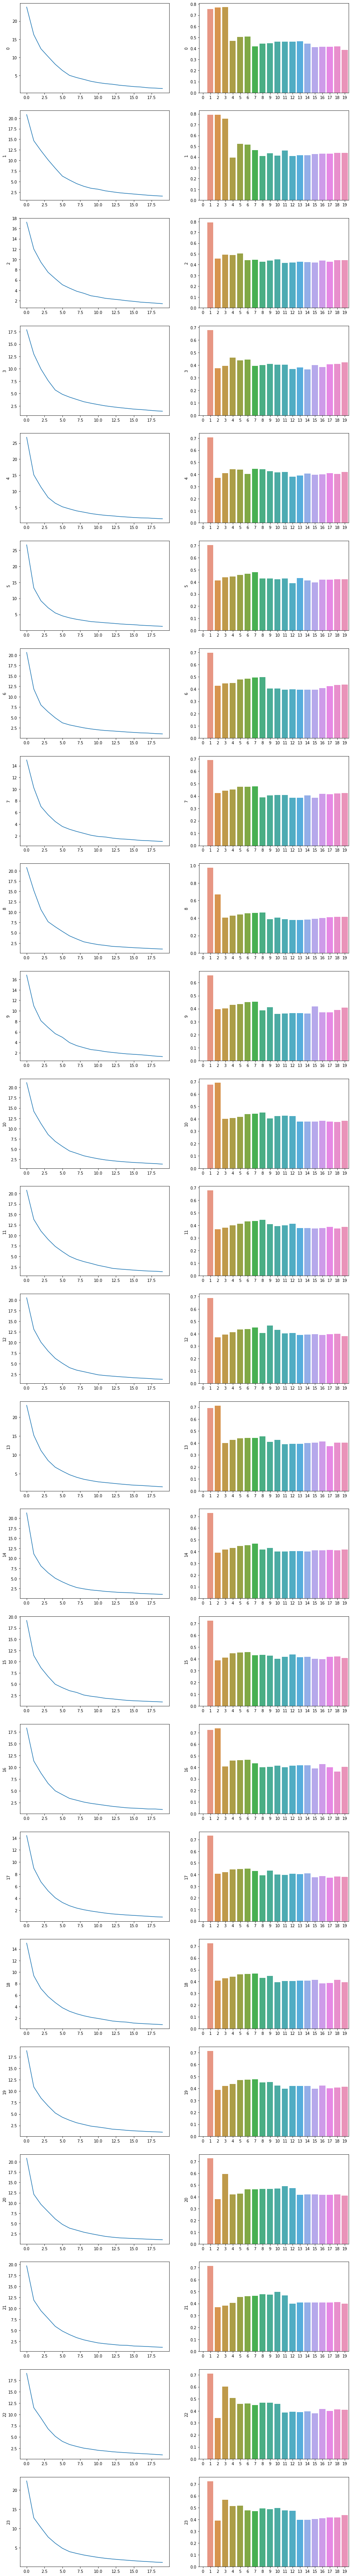

In [21]:
fig, axs = plt.subplots(24, 2, figsize=(15, 120))

for i in range(0,24):
    # Create a DataFrame that will be fed to plotly 
    wcss_frame = pd.DataFrame([WCSS[i]]).transpose()
    cluster_scores = pd.DataFrame([SIL[i]]).transpose()
    # Creating a line plot
    sns.lineplot(data=wcss_frame, x=wcss_frame.index, y=wcss_frame.iloc[:, -1], ax = axs[i, 0])
    sns.barplot(data=cluster_scores, x=cluster_scores.index, y=cluster_scores.iloc[:, -1], ax = axs[i, 1] )
    
fig.show()

In [22]:
# from the analysis of the graphs above, we can determine a number of cluster for each hour
cluster_hour_dict = { 0:"12", 1:"15", 2:"15" ,3:"14", 4:"7", 5:"6", 6:"6" , 7:"6", 8:"8", 9:"7", 
                      10:"6", 11:"8" , 12:"7", 13:"7", 14:"7", 15:"7", 16:"5", 17:"6", 18:"7", 
                      19:"6", 20:"8", 21:"12", 22:"12", 23:"11" }

In [23]:
X["cluster_hour"] = 0
for key, value in cluster_hour_dict.items():    
    mask = X["hours"] == key
    value = int(value)
    kmeans = MiniBatchKMeans(n_clusters = value, init = "k-means++", random_state = 1)
    kmeans.fit(X.loc[mask,:])
    X.loc[mask,"cluster_hour"] = kmeans.predict(X.loc[mask,:]) 

In [24]:
X["cluster_hour"] = X["cluster_hour"].apply(str)
fig = px.scatter_mapbox(X, lat="Lat", lon="Lon", color="cluster_hour", animation_frame="hours",
                        zoom=10,title="NYC clusters by hour",
                        mapbox_style="carto-positron")

fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()    

## Kmeans by weekday

In [25]:
dataset_weekday = stratified_sample_df(dataset, "weekday", 10000)
X =  dataset_weekday[['Lat', 'Lon', 'day_of_week']]
display(X.shape)
display(X.head())

(70000, 3)

,Lat,Lon,day_of_week
224982,40.7232,-73.9928,4
543440,40.7187,-73.9639,4
352276,40.7352,-74.0020,4
581215,40.7033,-74.0100,4
429403,40.7274,-74.0074,4


In [26]:
# Within-sum-of-square (wcss) for each value K for each hour saved in dataframe WCSS
wcss =  []
for x in range(0, 7):   
    for i in range (1,21):
        mask = X["day_of_week"] == x
        kmeans = KMeans(n_clusters= i, init = "k-means++", random_state = 0)
        kmeans.fit(X.loc[mask,:])
        wcss.append(kmeans.inertia_)
wcss = np.array(wcss).reshape(7,20)
WCSS = pd.DataFrame(wcss)
WCSS = WCSS.transpose()
display(WCSS.head())

# Computer mean silhouette score for each hour saved in dataframe SIL
sil = []
for x in range(0, 7): 
    sil.append(0)
    for i in range (2,21): 
        mask = X["day_of_week"] == x
        kmeans = KMeans(n_clusters= i, init = "k-means++", random_state = 0)
        kmeans.fit(X.loc[mask,:])
        sil.append(silhouette_score(X.loc[mask,:], kmeans.predict(X.loc[mask,:])))
sil = np.array(sil).reshape(7,20)
SIL = pd.DataFrame(sil)
SIL = SIL.transpose()
display(SIL.head())

,0,1,2,3,4,5,6
0,55.446606,42.190322,39.021992,39.723940,42.987008,53.864836,67.274617
1,33.105989,26.317136,24.032658,25.498645,27.317036,35.056615,39.389213
2,25.766238,20.027635,18.125952,19.746590,20.977690,27.215129,30.425521
3,18.743534,15.549065,14.500653,16.036788,17.271504,22.743666,23.619622
4,14.094603,11.813817,11.011924,12.165229,14.036542,19.240945,18.557122


,0,1,2,3,4,5,6
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.691818,0.722106,0.733091,0.718103,0.717470,0.716585,0.651019
2,0.367759,0.393252,0.392563,0.389460,0.382015,0.367312,0.393860
3,0.482642,0.413427,0.410461,0.402976,0.387474,0.404601,0.478323
4,0.430374,0.432336,0.427314,0.421641,0.405721,0.418339,0.467957


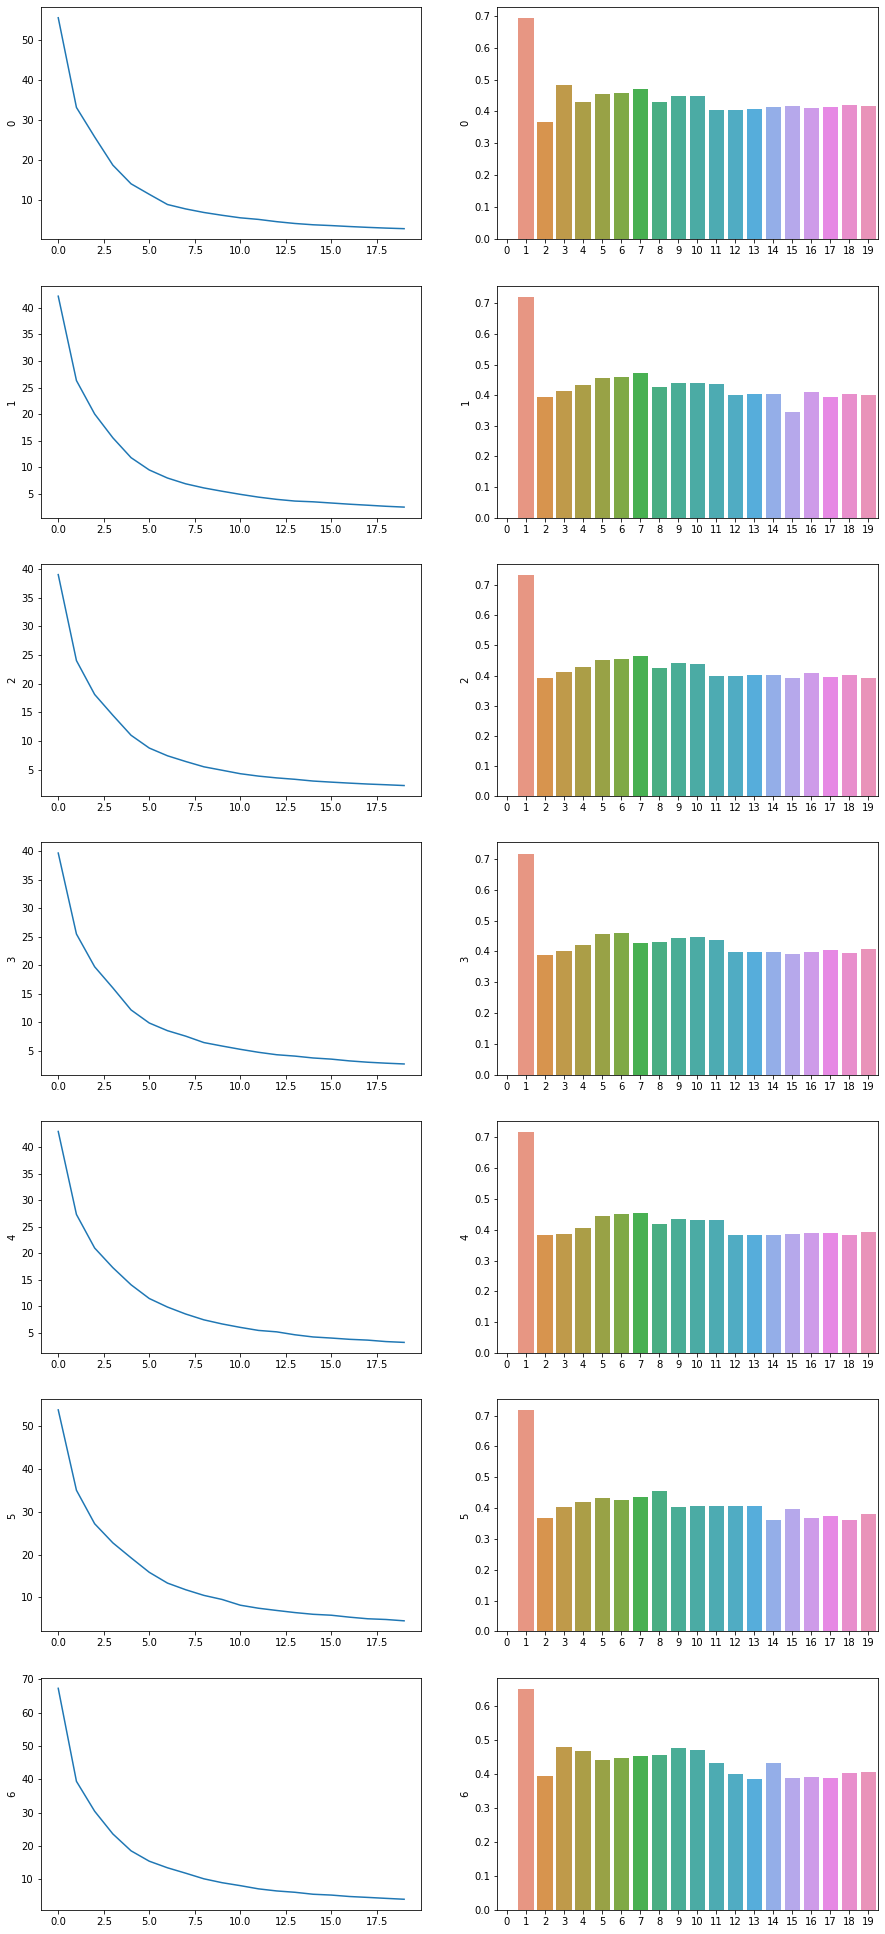

In [27]:
fig, axs = plt.subplots(7, 2, figsize=(15, 35))

for i in range(0,7):
    # Create a DataFrame that will be fed to plotly 
    wcss_frame = pd.DataFrame([WCSS[i]]).transpose()
    cluster_scores = pd.DataFrame([SIL[i]]).transpose()
    # Creating a line plot
    sns.lineplot(data=wcss_frame, x=wcss_frame.index, y=wcss_frame.iloc[:, -1], ax = axs[i, 0])
    sns.barplot(data=cluster_scores, x=cluster_scores.index, y=cluster_scores.iloc[:, -1], ax = axs[i, 1] )
    
fig.show()

In [28]:
# From the analysis of the graphs above, we can determine a number of cluster for each weekday
weekday_cluster_dict = { 0:"9", 1:"9", 2:"10" ,3:"9", 4:"9", 5:"9", 6:"8"}

In [29]:
X["cluster_weekday"] = 0
for key, value in weekday_cluster_dict.items():    
    mask = X["day_of_week"] == key
    value = int(value)
    kmeans = MiniBatchKMeans(n_clusters = value, init = "k-means++", random_state = 1)
    kmeans.fit(X.loc[mask,:])
    X.loc[mask,"cluster_weekday"] = kmeans.predict(X.loc[mask,:]) 
X["cluster_weekday"] = X["cluster_weekday"].apply(str)
X = X.sort_values("day_of_week")

In [30]:
X["cluster_weekday"].value_counts()

0    18517
7    11161
3     8974
2     8576
1     6506
4     5583
5     4385
8     3469
6     2277
9      552
Name: cluster_weekday, dtype: int64

In [31]:
import plotly.express as px

fig = px.scatter_mapbox(X, lat="Lat", lon="Lon", color="cluster_weekday", animation_frame="day_of_week",
                        zoom=9,
                        mapbox_style="carto-positron")

fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()

### DBSCAN around midnight

In [32]:
X = dataset_midnight[["Lat","Lon"]]
X.head()

,Lat,Lon
125693,40.7046,-74.0094
520892,40.7954,-74.4807
404352,40.7525,-73.9944
659350,40.7387,-74.0305
293850,40.7685,-73.9911


In [33]:
# initiate dbscan eps and min_samples optimized by multiple try
db = DBSCAN(eps=0.002, min_samples=50 , metric="manhattan", algorithm="brute")
db.fit(X)
display(np.unique(db.labels_))
display(db.labels_)
# creating a new column with the clusters that dbscan found
X["cluster_midnight"] = db.labels_
X["cluster_midnight"] = X["cluster_midnight"].apply(str)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

array([-1, -1, -1, ..., -1,  3, -1])

In [34]:
# visualisation on the map
fig = px.scatter_mapbox(
        X[X.cluster_midnight.apply(float) != -1], 
        lat="Lat", 
        lon="Lon",
        color="cluster_midnight",
        center={"lat":40.72,"lon":-73.97},
        zoom=11,
        mapbox_style="open-street-map",
        title="DBSCAN by midnight"
)

fig.show()

####    We can see that the visualisation look better than with kmeans

In [35]:
X = dataset_hours[["Lat","Lon","hours"]]
X.head()

,Lat,Lon,hours
741212,40.7023,-73.8555,0
469093,40.7500,-73.9862,0
112642,40.7217,-73.9934,0
507981,40.7183,-73.9918,0
363754,40.7499,-73.9859,0


In [36]:
X.shape

(96000, 3)

In [37]:
X["cluster_hour"] = 0
for x in range(0, 24): 
    mask = X["hours"] == x
    db = DBSCAN(eps=0.002, min_samples=30 , metric="manhattan", algorithm="brute")
    db.fit(X.loc[mask,:])
    X.loc[mask,"cluster_hour"] = db.labels_
X["cluster_hour"] = X["cluster_hour"].apply(str)

In [38]:
fig = px.scatter_mapbox(
        X[X.cluster_hour.apply(float) != -1],
        lat="Lat", 
        lon="Lon",
        color="cluster_hour",
        mapbox_style="open-street-map",
        animation_frame="hours",
        zoom = 10
)

fig.show()

### DBSCAN by weekday

In [39]:
X = dataset_weekday[["Lat","Lon","day_of_week"]]
X.head()

,Lat,Lon,day_of_week
224982,40.7232,-73.9928,4
543440,40.7187,-73.9639,4
352276,40.7352,-74.0020,4
581215,40.7033,-74.0100,4
429403,40.7274,-74.0074,4


In [40]:
X.describe()

,Lat,Lon,day_of_week
count,70000.000000,70000.000000,70000.000000
mean,40.739069,-73.972888,3.000000
std,0.040065,0.057256,2.000014
min,39.982700,-74.635600,0.000000
25%,40.720900,-73.996500,1.000000
50%,40.742100,-73.983400,3.000000
75%,40.761000,-73.964500,5.000000
max,41.225000,-72.886600,6.000000


In [41]:
X["cluster_weekday"] = 0
for x in range(0, 7): 
    mask = X["day_of_week"] == x
    db = DBSCAN(eps=0.001, min_samples=20 , metric="manhattan", algorithm="brute")
    db.fit(X.loc[mask,:])
    X.loc[mask,"cluster_weekday"] = db.labels_
X["cluster_weekday"] = X["cluster_weekday"].apply(str)

In [42]:
X = X.sort_values("day_of_week")
fig = px.scatter_mapbox(
        X[X.cluster_weekday.apply(float) != -1],
        lat="Lat", 
        lon="Lon",
        color="cluster_weekday",
        mapbox_style="open-street-map",
        animation_frame="day_of_week",
        zoom = 10
)

fig.show()

### DBSCAN by Month

In [43]:
dataset_month = stratified_sample_df(dataset, "month", 15000)
X = dataset_month[["Lat","Lon","month"]]
display(X.shape)

(90000, 3)

In [44]:
X["cluster_month"] = -2
for x in range(4, 10): 
    mask = X["month"] == x
    db = DBSCAN(eps=0.0015, min_samples=60 , metric="manhattan", algorithm="brute")
    db.fit(X.loc[mask,:])
    X.loc[mask,"cluster_month"] = db.labels_
X = X.sort_values("month")
X = X[X.cluster_month != -1]
X["cluster_month"] = X["cluster_month"].astype(str)

In [45]:
fig = px.scatter_mapbox(
        X[X.cluster_month.apply(float) != -1], 
        lat="Lat", 
        lon="Lon",
        color="cluster_month",
        mapbox_style="open-street-map",
        animation_frame="month",
        zoom = 9
)

fig.show()

### In this section we we'll work on the file jan-june 2015
    this file doesn't provide coordonates for map visualisation, we'll use our nyc.csv file for that

In [46]:
df_2015 = pd.read_csv("uber-raw-data-janjune-15.csv")
display(df_2015.shape)
display(df_2015.head())

(14270479, 4)

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
0,B02617,2015-05-17 09:47:00,B02617,141
1,B02617,2015-05-17 09:47:00,B02617,65
2,B02617,2015-05-17 09:47:00,B02617,100
3,B02617,2015-05-17 09:47:00,B02774,80
4,B02617,2015-05-17 09:47:00,B02617,90


In [47]:
df_2015 = df_2015.sample(50000)

In [48]:
# Let's create new columns with the Pickup_date column

print(df_2015.shape)
df_2015["Pickup_date"] = pd.to_datetime(df_2015["Pickup_date"])
df_2015["hour"] = df_2015["Pickup_date"].dt.hour
df_2015["minute"] = df_2015["Pickup_date"].dt.minute
# this new column keep the minutes in the time with a float format, for example 12:30 equal to 12.5
df_2015['hour_minute']=df_2015["hour"]+ df_2015["minute"]/60.0
# those two column are created to keep the cyclical aspect of time (23:59 is very close to 0:01)
df_2015['sin_time']=np.sin(2.*np.pi*df_2015['hour_minute']/24.)
df_2015['cos_time']=np.cos(2.*np.pi*df_2015['hour_minute']/24.)

display(df_2015.describe(include="all",datetime_is_numeric=True))

(50000, 4)


,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,hour,minute,hour_minute,sin_time,cos_time
count,50000,50000,49411,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
unique,8,NaN,221,NaN,NaN,NaN,NaN,NaN,NaN
top,B02764,NaN,B02764,NaN,NaN,NaN,NaN,NaN,NaN
freq,20356,NaN,15514,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2015-04-07 13:16:00.797780224,NaN,152.020780,14.054920,29.496880,14.546535,-0.256630,0.037918
min,NaN,2015-01-01 00:14:51,NaN,3.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000
25%,NaN,2015-02-20 23:56:20,NaN,91.000000,9.000000,15.000000,9.683333,-0.863836,-0.669131
50%,NaN,2015-04-10 18:31:30,NaN,157.000000,16.000000,30.000000,16.033333,-0.422618,0.061049
75%,NaN,2015-05-23 10:11:30,NaN,230.000000,20.000000,44.000000,20.033333,0.271440,0.763232
max,NaN,2015-06-30 23:58:00,NaN,265.000000,23.000000,59.000000,23.983333,1.000000,1.000000


In [49]:
# Here we'll do the Kmeans on time and location ID
X = df_2015[['sin_time', 'cos_time','locationID']]
wcss =  []
for i in range (1,15): 
    kmeans = MiniBatchKMeans(n_clusters= i, init = "k-means++", random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Create a DataFrame that will be fed to plotly 
wcss_frame = pd.DataFrame(wcss)

# Using Plotly to visualize elbow 
import plotly.express as px 

# Creating a line plot
fig = px.line(wcss_frame, x=wcss_frame.index, y=wcss_frame.iloc[:, -1])

# Creating layouts 
fig.update_layout(
    title="Inertia per clusters",
    xaxis_title="# clusters",
    yaxis_title="Inertia"
)

# Render in notebook
fig.show()

In [50]:
# Computer mean silhouette score
sil = []

## Careful, you need to start at i=2 as silhouette score cannot accept less than 2 labels 
for i in range (2,15): 
    kmeans = MiniBatchKMeans(n_clusters= i, init = "k-means++", random_state = 0)
    kmeans.fit(X)
    sil.append(silhouette_score(X, kmeans.predict(X)))
    print("Silhouette score for K={} is {}".format(i, sil[-1]))
    
# Create a data frame 
cluster_scores=pd.DataFrame(sil, index=range(2,15))

# Create figure
fig = px.bar(data_frame=cluster_scores,  
             x=cluster_scores.index, 
             y=cluster_scores.iloc[:, -1]
            )

# Add title and axis labels
fig.update_layout(
    yaxis_title="Silhouette Score",
    xaxis_title="# Clusters",
    title="Silhouette Score per cluster"
)

# Render
fig.show()

Silhouette score for K=2 is 0.5983628665935135
Silhouette score for K=3 is 0.6813446403325726
Silhouette score for K=4 is 0.6756330200202709
Silhouette score for K=5 is 0.6438230154690325
Silhouette score for K=6 is 0.641273446928279
Silhouette score for K=7 is 0.6190513313748179
Silhouette score for K=8 is 0.642325757767527
Silhouette score for K=9 is 0.642551869428125
Silhouette score for K=10 is 0.6452761810124445
Silhouette score for K=11 is 0.5885055858885879
Silhouette score for K=12 is 0.5816848412102452
Silhouette score for K=13 is 0.6506656249612135
Silhouette score for K=14 is 0.6277156337634386


In [51]:
kmeans = MiniBatchKMeans(n_clusters=11, init = "k-means++", random_state = 0)
kmeans.fit(X)
X["cluster"] = kmeans.predict(X)

In [52]:
X.head()

,sin_time,cos_time,locationID,cluster
12713653,-0.370557,0.928810,234,1
7437960,0.237686,-0.971342,238,1
132049,0.182236,-0.983255,230,10
12421632,-0.284015,-0.958820,229,10
13293317,0.816642,-0.577145,237,1


In [53]:
cluster_hour_2015 = pd.merge(X, df_2015, left_index=True, right_index=True)

In [54]:
cluster_hour_2015.head()

,sin_time_x,cos_time_x,locationID_x,cluster,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID_y,hour,minute,hour_minute,sin_time_y,cos_time_y
12713653,-0.370557,0.928810,234,1,B02765,2015-03-12 22:33:00,B02765,234,22,33,22.550000,-0.370557,0.928810
7437960,0.237686,-0.971342,238,1,B02617,2015-01-22 11:05:12,B02617,238,11,5,11.083333,0.237686,-0.971342
132049,0.182236,-0.983255,230,10,B02682,2015-05-17 11:18:00,B02682,230,11,18,11.300000,0.182236,-0.983255
12421632,-0.284015,-0.958820,229,10,B02765,2015-03-02 13:06:00,B02765,229,13,6,13.100000,-0.284015,-0.958820
13293317,0.816642,-0.577145,237,1,B02764,2015-05-07 08:21:00,B02764,237,8,21,8.350000,0.816642,-0.577145


In [55]:
cluster_hour_2015 = cluster_hour_2015[["locationID_x","hour","cluster"]]

In [56]:
cluster_hour_2015.columns =  ["LocationID","hour","cluster"]

In [57]:
# Let's add the geographical informations
cluster_hour_2015 = pd.merge(cluster_hour_2015, nyc_zone, on='LocationID') 
cluster_hour_2015.head()

,LocationID,hour,cluster,Zone,Zone_Lat,Zone_Lon,borough_ID,Borough,borough_lat,borough_lon,borough_boundingbox
0,234,22,1,Union Sq,40.736186,-73.989343,4.0,Manhattan,40.789624,-73.959894,"['40.6839411', '40.8804489', '-74.0472219', '-..."
1,234,22,1,Union Sq,40.736186,-73.989343,4.0,Manhattan,40.789624,-73.959894,"['40.6839411', '40.8804489', '-74.0472219', '-..."
2,234,19,1,Union Sq,40.736186,-73.989343,4.0,Manhattan,40.789624,-73.959894,"['40.6839411', '40.8804489', '-74.0472219', '-..."
3,234,19,1,Union Sq,40.736186,-73.989343,4.0,Manhattan,40.789624,-73.959894,"['40.6839411', '40.8804489', '-74.0472219', '-..."
4,234,23,1,Union Sq,40.736186,-73.989343,4.0,Manhattan,40.789624,-73.959894,"['40.6839411', '40.8804489', '-74.0472219', '-..."


In [58]:
cluster_hour_2015["cluster"] = cluster_hour_2015["cluster"].astype(str)
cluster_hour_2015 = cluster_hour_2015.sort_values("hour")

In [59]:
import plotly.express as px

fig = px.scatter_mapbox(cluster_hour_2015, lat="Zone_Lat", lon="Zone_Lon", color="cluster",
                        zoom=10,
                        mapbox_style="open-street-map",
                        animation_frame="hour",
                        center={"lat":40.736186, "lon":-73.989343},
                        hover_data = ["Zone","Borough"])

fig.show("iframe")

#### With this final map we can see the zones of New York where there should be enough car depending on the hour, it's not very good for real hot zones vizualisation

### Conclusion
    Our results were better with Dbscan and the geographical data from 2014. the choice of epsilon and the number of observations in the area determined by epsilon was the main task to get a valid visualisation of clustering(particularly by hour and day of week). We now have hot zones evolving in time that we can provide to Uber to develop their activity in New York.